In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
import xgboost
from xgboost import XGBRegressor, XGBClassifier

In [4]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import max_num_bins, Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve


# AUX FUNCTION TO FIND SOLUTIONS

def dx(fn, x, delta=0.001):
    return (fn(x+delta) - fn(x))/delta

def solvecross(fn, value, x=-45.5, maxtries=1000, maxerr=0.00001):
    for tries in range(maxtries):
        err = fn(x) - value
        if abs(err) < maxerr:
            return x
        slope = dx(fn, x)
        x -= err/slope
    raise ValueError('no solution found')

### DATA

In [5]:
mDM = 500

filefolder = '../../data2024/processed/cs1cs2/'

In [6]:
##############
# PARAMETERS #
##############

tot_B = 634.55+2.26+0.01+0.6+5.34

f_ER = 634.55 / tot_B
f_AC = 2.26 / tot_B
f_CNNS = 0.01 / tot_B
f_RN = 0.6 / tot_B
f_WALL = 5.34 / tot_B

f_ER + f_AC + f_CNNS + f_RN + f_WALL

S_cross1045 = 33.24

cross_factor = np.logspace(-47,-44,10) / 1e-45
S_expected = [max(1, round(S_cross1045 * fac)) for fac in cross_factor]


# DISCOVERY: 'discovery', EXCLUSION: 'exclusion'
D_or_E = 'exclusion'

# requested number of pseudo experiments
num_pseudo = 2000

# number of expected background events per ensemble
B_expected = round(tot_B)

print('B_expected: ', B_expected)
print('S_cross1045: ', S_cross1045)
print('S_expected (from cross=1e-47 to 1e-44): ', S_expected)

B_expected:  643
S_cross1045:  33.24
S_expected (from cross=1e-47 to 1e-44):  [1, 1, 2, 3, 7, 15, 33, 72, 154, 332]


In [7]:
###############
# BACKGROUNDS # 
###############

B_cs1_ER = np.loadtxt(filefolder + 'ER_cs1.txt')
B_cs2_ER = np.loadtxt(filefolder + 'ER_cs2.txt')

print('B_cs1_ER.shape: ', B_cs1_ER.shape)
print('B_cs2_ER.shape: ', B_cs2_ER.shape)


B_cs1_AC = np.loadtxt(filefolder + 'AC_cs1.txt')
B_cs2_AC = np.loadtxt(filefolder + 'AC_cs2.txt')

print('\nB_cs1_AC.shape: ', B_cs1_AC.shape)
print('B_cs2_AC.shape: ', B_cs2_AC.shape)


B_cs1_CNNS = np.loadtxt(filefolder + 'CNNS_cs1.txt')
B_cs2_CNNS = np.loadtxt(filefolder + 'CNNS_cs2.txt')

print('\nB_cs1_CNNS.shape: ', B_cs1_CNNS.shape)
print('B_cs2_CNNS.shape: ', B_cs2_CNNS.shape)


B_cs1_RN = np.loadtxt(filefolder + 'RN_cs1.txt')
B_cs2_RN = np.loadtxt(filefolder + 'RN_cs2.txt')

print('\nB_cs1_RN.shape: ', B_cs1_RN.shape)
print('B_cs2_RN.shape: ', B_cs2_RN.shape)


B_cs1_WALL = np.loadtxt(filefolder + 'WALL_cs1.txt')
B_cs2_WALL = np.loadtxt(filefolder + 'WALL_cs2.txt')

print('\nB_cs1_WALL.shape: ', B_cs1_WALL.shape)
print('B_cs2_WALL.shape: ', B_cs2_WALL.shape)


##########
# SIGNAL #
##########

S_cs1 = np.loadtxt(filefolder + 'WIMP_' + str(mDM) + 'GeV_cs1.txt')
S_cs2 = np.loadtxt(filefolder + 'WIMP_' + str(mDM) + 'GeV_cs2.txt')

print('\nS_cs1.shape: ', S_cs1.shape)
print('S_cs2.shape: ', S_cs2.shape)

B_cs1_ER.shape:  (67300,)
B_cs2_ER.shape:  (67300,)

B_cs1_AC.shape:  (5000,)
B_cs2_AC.shape:  (5000,)

B_cs1_CNNS.shape:  (43,)
B_cs2_CNNS.shape:  (43,)

B_cs1_RN.shape:  (4516,)
B_cs2_RN.shape:  (4516,)

B_cs1_WALL.shape:  (5000,)
B_cs2_WALL.shape:  (5000,)

S_cs1.shape:  (35477,)
S_cs2.shape:  (35477,)


In [33]:
# # cs1 = [3, 70] PE
# # cS2 = [50, 8000] PE

# B_cs1_ER_aux = [B_cs1_ER[x] for x in range(len(B_cs1_ER)) if (3 < B_cs1_ER[x] < 70 and 50 < B_cs2_ER[x] < 8000)]
# B_cs2_ER = [B_cs2_ER[x] for x in range(len(B_cs1_ER)) if (3 < B_cs1_ER[x] < 70 and 50 < B_cs2_ER[x] < 8000)]
# B_cs1_ER = B_cs1_ER_aux

# B_cs1_AC_aux = [B_cs1_AC[x] for x in range(len(B_cs1_AC)) if (3 < B_cs1_AC[x] < 70 and 50 < B_cs2_AC[x] < 8000)]
# B_cs2_AC = [B_cs2_AC[x] for x in range(len(B_cs1_AC)) if (3 < B_cs1_AC[x] < 70 and 50 < B_cs2_AC[x] < 8000)]
# B_cs1_AC = B_cs1_AC_aux

# B_cs1_CNNS_aux = [B_cs1_CNNS[x] for x in range(len(B_cs1_CNNS)) if (3 < B_cs1_CNNS[x] < 70 and 50 < B_cs2_CNNS[x] < 8000)]
# B_cs2_CNNS = [B_cs2_CNNS[x] for x in range(len(B_cs1_CNNS)) if (3 < B_cs1_CNNS[x] < 70 and 50 < B_cs2_CNNS[x] < 8000)]
# B_cs1_CNNS = B_cs1_CNNS_aux

# B_cs1_RN_aux = [B_cs1_RN[x] for x in range(len(B_cs1_RN)) if (3 < B_cs1_RN[x] < 70 and 50 < B_cs2_RN[x] < 8000)]
# B_cs2_RN = [B_cs2_RN[x] for x in range(len(B_cs1_RN)) if (3 < B_cs1_RN[x] < 70 and 50 < B_cs2_RN[x] < 8000)]
# B_cs1_RN = B_cs1_RN_aux

# B_cs1_WALL_aux = [B_cs1_WALL[x] for x in range(len(B_cs1_WALL)) if (3 < B_cs1_WALL[x] < 70 and 50 < B_cs2_WALL[x] < 8000)]
# B_cs2_WALL = [B_cs2_WALL[x] for x in range(len(B_cs1_WALL)) if (3 < B_cs1_WALL[x] < 70 and 50 < B_cs2_WALL[x] < 8000)]
# B_cs1_WALL = B_cs1_WALL_aux


# S_cs1_aux = [S_cs1[x] for x in range(len(S_cs1)) if (3 < S_cs1[x] < 70 and 50 < S_cs2[x] < 8000)]
# S_cs2 = [S_cs2[x] for x in range(len(S_cs1)) if (3 < S_cs1[x] < 70 and 50 < S_cs2[x] < 8000)]
# S_cs1 = S_cs1_aux


##### Select the number of events per class

In [9]:
NUM_DAT = min(len(B_cs1_ER), len(S_cs1))
print(' NUM_DAT: ', NUM_DAT, '\n')

NUM_DAT_AC = int(NUM_DAT*f_AC)
NUM_DAT_CNNS = max(1, int(NUM_DAT*f_CNNS))
NUM_DAT_RN = int(NUM_DAT*f_RN)
NUM_DAT_WALL = int(NUM_DAT*f_WALL)

NUM_DAT_ER = NUM_DAT - ( NUM_DAT_AC + NUM_DAT_CNNS + NUM_DAT_RN + NUM_DAT_WALL )

print('NUM_DAT_ER: ', NUM_DAT_ER)
print('NUM_DAT_AC: ', NUM_DAT_AC)
print('NUM_DAT_CNNS: ', NUM_DAT_CNNS)
print('NUM_DAT_RN: ', NUM_DAT_RN)
print('NUM_DAT_WALL: ', NUM_DAT_WALL)



# CONCATENATE THE BACKGROUNDS
B_cs1cs2 = np.concatenate([np.stack([B_cs1_ER,B_cs2_ER],axis=1)[:NUM_DAT_ER], np.stack([B_cs1_AC,B_cs2_AC],axis=1)[:NUM_DAT_AC], np.stack([B_cs1_CNNS,B_cs2_CNNS],axis=1)[:NUM_DAT_CNNS], np.stack([B_cs1_RN,B_cs2_RN],axis=1)[:NUM_DAT_RN], np.stack([B_cs1_WALL,B_cs2_WALL],axis=1)[:NUM_DAT_WALL]])

print('\nB_cs1cs2.shape: ', B_cs1cs2.shape)


S_cs1cs2 = np.stack([S_cs1,S_cs2],axis=1)[:NUM_DAT]


print('\nS_cs1cs2.shape: ', S_cs1cs2.shape)

 NUM_DAT:  35477 

NUM_DAT_ER:  35025
NUM_DAT_AC:  124
NUM_DAT_CNNS:  1
NUM_DAT_RN:  33
NUM_DAT_WALL:  294

B_cs1cs2.shape:  (35477, 2)

S_cs1cs2.shape:  (35477, 2)


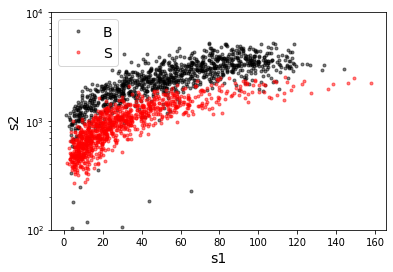

In [10]:
rnd = 100

B_cs1cs2_plot = shuffle(B_cs1cs2, random_state=rnd)
S_cs1cs2_plot = shuffle(S_cs1cs2, random_state=rnd)

plt.plot(B_cs1cs2_plot[:,0][:1000], B_cs1cs2_plot[:,1][:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_cs1cs2_plot[:,0][:1000], S_cs1cs2_plot[:,1][:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
plt.ylim([100,10000])
plt.xlabel('s1',fontsize=14)
plt.ylabel('s2',fontsize=14)
plt.legend(fontsize=14)
plt.show()

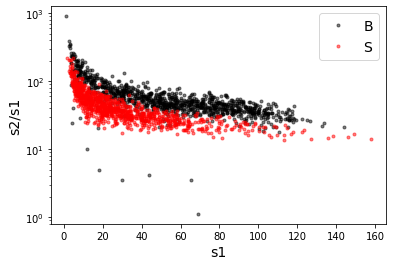

In [11]:
plt.plot(B_cs1cs2_plot[:,0][:1000], (B_cs1cs2_plot[:,1] / B_cs1cs2_plot[:,0])[:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_cs1cs2_plot[:,0][:1000], (S_cs1cs2_plot[:,1] / S_cs1cs2_plot[:,0])[:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
# plt.ylim([100,10000])
plt.xlabel('s1',fontsize=14)
plt.ylabel('s2/s1',fontsize=14)
plt.legend(fontsize=14)
plt.show()

## 1. cS1 and cS2

In [12]:
# concatenate the data
X_mon_B = B_cs1cs2
X_mon_S = S_cs1cs2

# X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))
# X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))
print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)

# del B_ppeakS1
# del B_ppeakS2
# del B_pbot
# del B_ptop

# del S_ppeakS1
# del S_ppeakS2
# del S_pbot
# del S_ptop

X_mon = np.concatenate([X_mon_B, X_mon_S])

# X_mon = np.concatenate([np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(S_pbot,(len(S_pbot),1))])

print('X_mon.shape: ', X_mon.shape)
# del X_mon_B
# del X_mon_S


# labels
y_mon = np.concatenate([np.zeros(NUM_DAT),np.ones(NUM_DAT)])


# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

X_mon_B.shape:  (35477, 2)
X_mon_S.shape:  (35477, 2)
X_mon.shape:  (70954, 2)

X_mon_train :  (45232, 2)
y_mon_train :  (45232,)
X_mon_val :  (7983, 2)
y_mon_val :  (7983,)
X_mon_test :  (17739, 2)
y_mon_test :  (17739,)



## CLASSIFIERS

### XGBoost

[0]	validation_0-logloss:0.62027	validation_1-logloss:0.62058
[1]	validation_0-logloss:0.56039	validation_1-logloss:0.56116


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-logloss:0.51019	validation_1-logloss:0.51128
[3]	validation_0-logloss:0.46762	validation_1-logloss:0.46875
[4]	validation_0-logloss:0.43077	validation_1-logloss:0.43238
[5]	validation_0-logloss:0.39909	validation_1-logloss:0.40071
[6]	validation_0-logloss:0.37184	validation_1-logloss:0.37387
[7]	validation_0-logloss:0.34809	validation_1-logloss:0.35013
[8]	validation_0-logloss:0.32736	validation_1-logloss:0.32972
[9]	validation_0-logloss:0.30923	validation_1-logloss:0.31192
[10]	validation_0-logloss:0.29322	validation_1-logloss:0.29597
[11]	validation_0-logloss:0.27920	validation_1-logloss:0.28225
[12]	validation_0-logloss:0.26665	validation_1-logloss:0.26979
[13]	validation_0-logloss:0.25556	validation_1-logloss:0.25884
[14]	validation_0-logloss:0.24582	validation_1-logloss:0.24930
[15]	validation_0-logloss:0.23699	validation_1-logloss:0.24063
[16]	validation_0-logloss:0.22922	validation_1-logloss:0.23300
[17]	validation_0-logloss:0.22217	validation_1-logloss:0.22601


[132]	validation_0-logloss:0.15447	validation_1-logloss:0.16830
[133]	validation_0-logloss:0.15436	validation_1-logloss:0.16829
[134]	validation_0-logloss:0.15431	validation_1-logloss:0.16826
[135]	validation_0-logloss:0.15429	validation_1-logloss:0.16828
[136]	validation_0-logloss:0.15416	validation_1-logloss:0.16823
[137]	validation_0-logloss:0.15412	validation_1-logloss:0.16829
[138]	validation_0-logloss:0.15410	validation_1-logloss:0.16831
[139]	validation_0-logloss:0.15395	validation_1-logloss:0.16829
[140]	validation_0-logloss:0.15388	validation_1-logloss:0.16832
[141]	validation_0-logloss:0.15382	validation_1-logloss:0.16833
[142]	validation_0-logloss:0.15375	validation_1-logloss:0.16833
[143]	validation_0-logloss:0.15355	validation_1-logloss:0.16843
[144]	validation_0-logloss:0.15350	validation_1-logloss:0.16841
[145]	validation_0-logloss:0.15349	validation_1-logloss:0.16842
[146]	validation_0-logloss:0.15346	validation_1-logloss:0.16843
[147]	validation_0-logloss:0.15342	valid

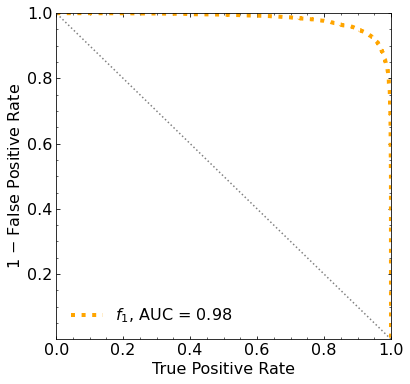

Classification score:


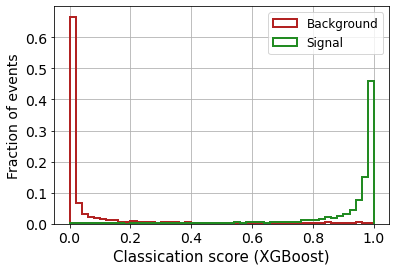


 ROC-AUC =  0.9821779694286985


In [13]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

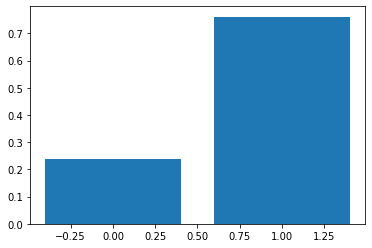

In [14]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

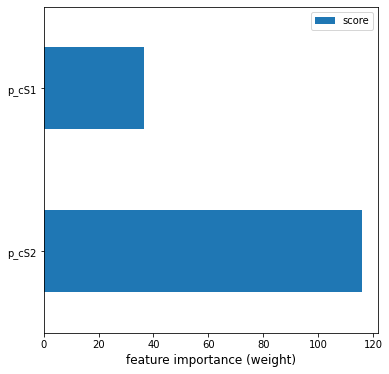

In [15]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
keys = ['p_cS1','p_cS2']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 40 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

In [16]:
keys

['p_cS1', 'p_cS2']

In [17]:

from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(classifier, X_mon_test, y_mon_test)


In [18]:


sorted_idx = classifier.feature_importances_.argsort()

sorted_idx_keys = []
for i in sorted_idx:
    sorted_idx_keys.append(keys[i])
    
sorted_idx_keys

['p_cS1', 'p_cS2']

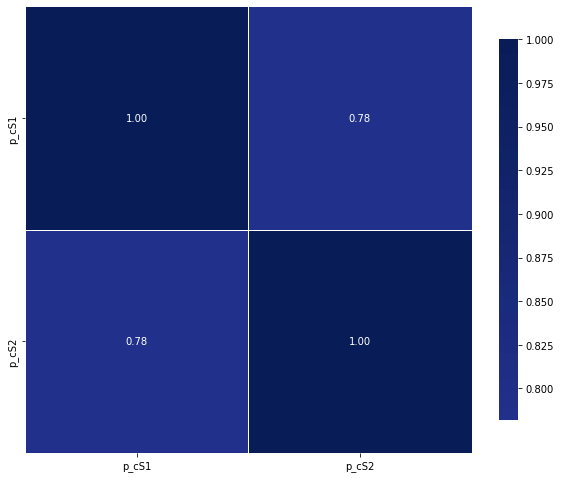

In [19]:
X = pd.DataFrame(X_mon_test, columns=keys)

def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(X[sorted_idx_keys])


In [20]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

# FIND THE NUMBER OF BINS:
num_bins = max_num_bins(pred_XG_SM, B_expected, range_dat, MIN_EVS, bins_to_test)

print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
print('min number of Background events allowed per bin: ', MIN_EVS)
print('number of bins we are going to use: ', num_bins)
print('range of our data: ', range_dat)

At least 5 B events per bin, range = [[0, 1]]:
# bins:  14 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
number of bins we are going to use:  14
range of our data:  [[0, 1]]


In [21]:
num_bins = 10

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.281


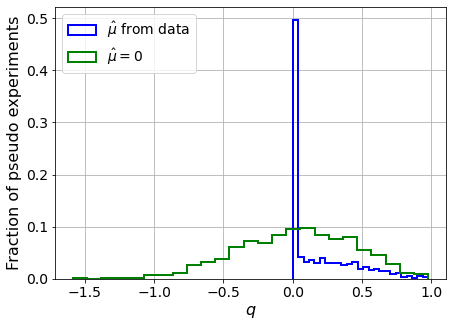

muhat mean:  0.24901447599449056
Z_bins:  0.20500958502054606
std Z_bins:  0.5758771172082087
Z_bins mu=0:  0.20450057290539214
std Z_bins mu=0:  1.0200543650439262

--------

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.243


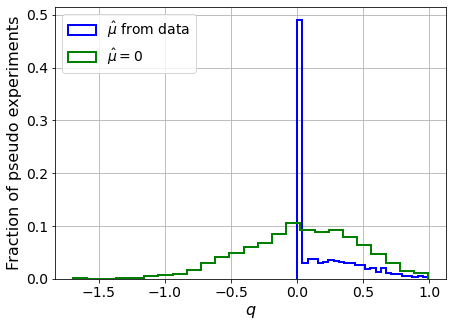

muhat mean:  0.1550956517106425
Z_bins:  0.2285488862211866
std Z_bins:  0.5313191142491631
Z_bins mu=0:  0.2285488862211866
std Z_bins mu=0:  0.9342962190921477

--------

B_expected:  643
S_expected:  2

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2665


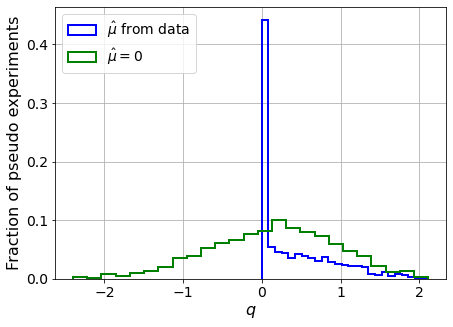

muhat mean:  0.1131733241750782
Z_bins:  0.418985873319872
std Z_bins:  0.5807713646743686
Z_bins mu=0:  0.4189226888520387
std Z_bins mu=0:  0.9563124129363962

--------

B_expected:  643
S_expected:  3

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2685


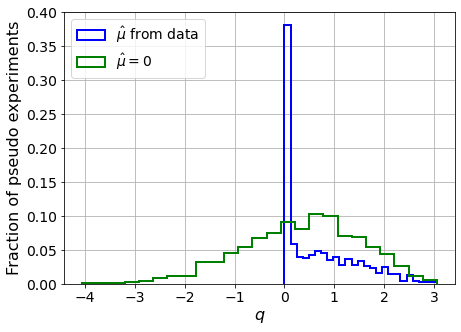

muhat mean:  0.07127209855081948
Z_bins:  0.6563759888409202
std Z_bins:  0.5657600630669123
Z_bins mu=0:  0.6563759888409202
std Z_bins mu=0:  0.9018092118848298

--------

B_expected:  643
S_expected:  7

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.253


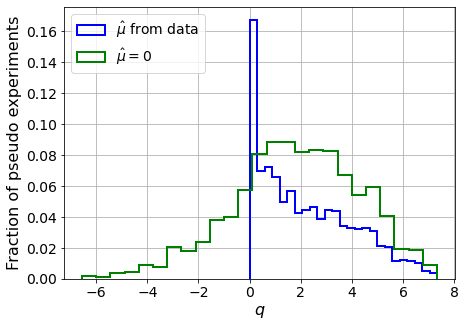

muhat mean:  0.016134230391399627
Z_bins:  1.373871627413321
std Z_bins:  0.6721460428556864
Z_bins mu=0:  1.3735629370248224
std Z_bins mu=0:  0.9008263976304551

--------

B_expected:  643
S_expected:  15

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2565


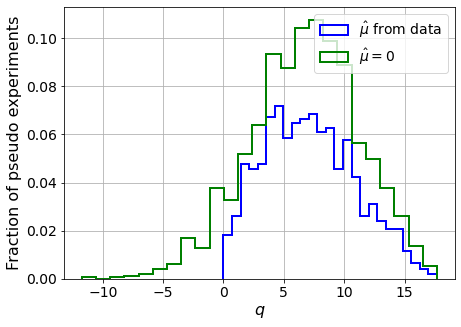

muhat mean:  0.020514509696334452
Z_bins:  2.631365337419779
std Z_bins:  0.71597918019583
Z_bins mu=0:  2.6304974125934675
std Z_bins mu=0:  0.8536164170077893

--------

B_expected:  643
S_expected:  33

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.273


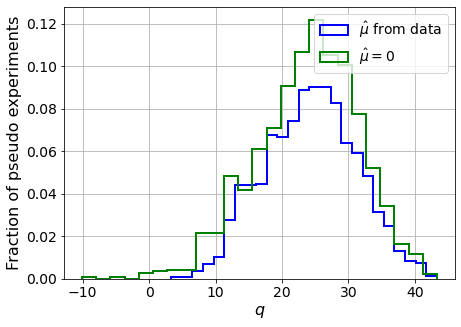

muhat mean:  0.00480615818482237
Z_bins:  4.94432323709438
std Z_bins:  0.6994466991370365
Z_bins mu=0:  4.94432323709438
std Z_bins mu=0:  0.7775962891817326

--------

B_expected:  643
S_expected:  72

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2585


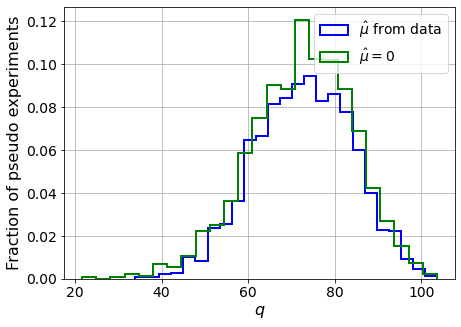

muhat mean:  0.003053376315440843
Z_bins:  8.546146893112727
std Z_bins:  0.6574108643338313
Z_bins mu=0:  8.545474414546481
std Z_bins mu=0:  0.7038493604388283

--------

B_expected:  643
S_expected:  154

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.266


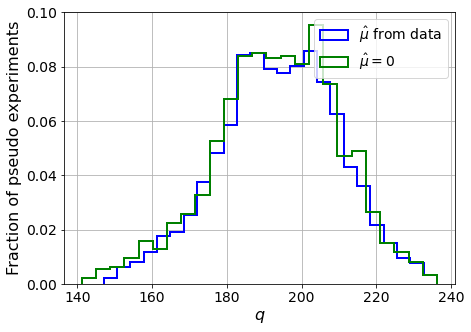

muhat mean:  0.0010815089658540774
Z_bins:  13.936711408477116
std Z_bins:  0.5739006631049256
Z_bins mu=0:  13.936705532157347
std Z_bins mu=0:  0.5997623145372779

--------

B_expected:  643
S_expected:  332

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2845


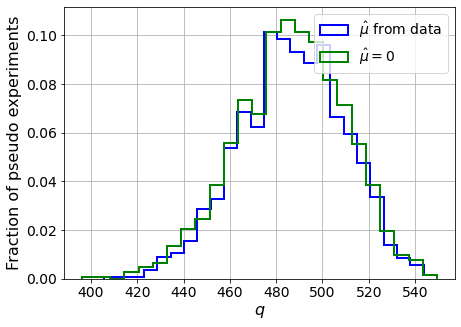

muhat mean:  0.000278812054485887
Z_bins:  22.071333720136753
std Z_bins:  0.5130657650414707
Z_bins mu=0:  22.071333720136753
std Z_bins mu=0:  0.528997379484449

--------


 FINAL RESULT:

[[0.20500958502054606, 0.5758771172082087, 0.24901447599449056, 0.20450057290539214, 1.0200543650439262], [0.2285488862211866, 0.5313191142491631, 0.1550956517106425, 0.2285488862211866, 0.9342962190921477], [0.418985873319872, 0.5807713646743686, 0.1131733241750782, 0.4189226888520387, 0.9563124129363962], [0.6563759888409202, 0.5657600630669123, 0.07127209855081948, 0.6563759888409202, 0.9018092118848298], [1.373871627413321, 0.6721460428556864, 0.016134230391399627, 1.3735629370248224, 0.9008263976304551], [2.631365337419779, 0.71597918019583, 0.020514509696334452, 2.6304974125934675, 0.8536164170077893], [4.94432323709438, 0.6994466991370365, 0.00480615818482237, 4.94432323709438, 0.7775962891817326], [8.546146893112727, 0.6574108643338313, 0.003053376315440843, 8.545474414546481, 0.70384936043

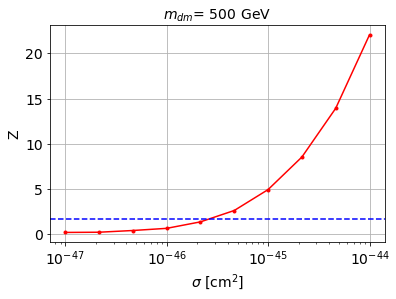


cross_BL_164:  2.534416494630077e-46
cross_BL_164_up:  1.4759209681975649e-46
cross_BL_164_down:  3.899702958701089e-46


In [25]:
# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []


for s_it in range(len(S_expected)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[s_it])
    print('')

    Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, S_expected[s_it], num_pseudo, num_bins, range_dat, MIN_EVS, linear_bins=True) 
    
    store_Z_BL.append( list(Z_BL) )
    
    print('muhat mean: ', Z_BL[2])
    print('Z_bins: ', Z_BL[0])
    print('std Z_bins: ', Z_BL[1])
    print('Z_bins mu=0: ', Z_BL[3])
    print('std Z_bins mu=0: ', Z_BL[4])
    print('')
    print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)


# plot
plt.plot(cross_factor*1e-45, np.array(store_Z_BL)[:,0], '.-', c='red')

plt.axhline(y=1.64, c='blue', linestyle='--')
plt.title('$m_{dm}$= %0.2d GeV' % mDM, fontsize=14)
plt.xscale('log')
plt.xlabel(r'$\sigma$ [cm$^2$]', fontsize=14)
plt.ylabel(r'Z', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()


# interpolate
f_Z = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0], kind='linear')
f_Z_up = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] + np.array(store_Z_BL)[:,1], kind='linear')
f_Z_down = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] - np.array(store_Z_BL)[:,1], kind='linear')

# compute the cross section with Z=1.64
cross_BL_164 = 10**solvecross(f_Z, 1.64)
cross_BL_164_up = 10**solvecross(f_Z_up, 1.64)
cross_BL_164_down = 10**solvecross(f_Z_down, 1.64)

print('\ncross_BL_164: ', cross_BL_164)
print('cross_BL_164_up: ', cross_BL_164_up)
print('cross_BL_164_down: ', cross_BL_164_down)

### DNN

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 4)                 12        
_________________________________________________________________
dropout_10 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 16)                80        
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_12 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

354/354 [==============================] - 0s 564us/step - loss: 0.2628 - accuracy: 0.9016 - val_loss: 0.3055 - val_accuracy: 0.8681
Epoch 105/500
354/354 [==============================] - 0s 537us/step - loss: 0.2617 - accuracy: 0.9011 - val_loss: 0.2861 - val_accuracy: 0.8749
Epoch 106/500
354/354 [==============================] - 0s 531us/step - loss: 0.2600 - accuracy: 0.9014 - val_loss: 0.3138 - val_accuracy: 0.8630
Epoch 107/500
354/354 [==============================] - 0s 553us/step - loss: 0.2567 - accuracy: 0.9032 - val_loss: 0.2726 - val_accuracy: 0.8822
Epoch 108/500
354/354 [==============================] - 0s 548us/step - loss: 0.2608 - accuracy: 0.9015 - val_loss: 0.2531 - val_accuracy: 0.8955
Epoch 109/500
354/354 [==============================] - 0s 533us/step - loss: 0.2577 - accuracy: 0.9037 - val_loss: 0.2855 - val_accuracy: 0.8772
Epoch 110/500
354/354 [==============================] - 0s 564us/step - loss: 0.2589 - accuracy: 0.9020 - val_loss: 0.2713 - val_ac

Epoch 160/500
354/354 [==============================] - 0s 527us/step - loss: 0.2540 - accuracy: 0.9043 - val_loss: 0.2972 - val_accuracy: 0.8673
Epoch 161/500
354/354 [==============================] - 0s 539us/step - loss: 0.2562 - accuracy: 0.9035 - val_loss: 0.2687 - val_accuracy: 0.8853
Epoch 162/500
354/354 [==============================] - 0s 532us/step - loss: 0.2503 - accuracy: 0.9070 - val_loss: 0.2305 - val_accuracy: 0.9096
Epoch 163/500
354/354 [==============================] - 0s 540us/step - loss: 0.2568 - accuracy: 0.9006 - val_loss: 0.2738 - val_accuracy: 0.8831
Epoch 164/500
354/354 [==============================] - 0s 534us/step - loss: 0.2561 - accuracy: 0.9039 - val_loss: 0.2594 - val_accuracy: 0.8908
Epoch 165/500
354/354 [==============================] - 0s 542us/step - loss: 0.2563 - accuracy: 0.9037 - val_loss: 0.2486 - val_accuracy: 0.8979
Epoch 166/500
354/354 [==============================] - 0s 537us/step - loss: 0.2560 - accuracy: 0.9038 - val_loss: 0

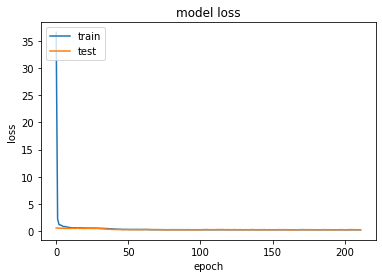

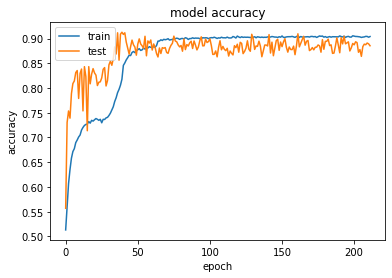

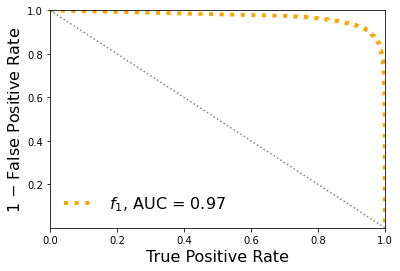

Classification score:


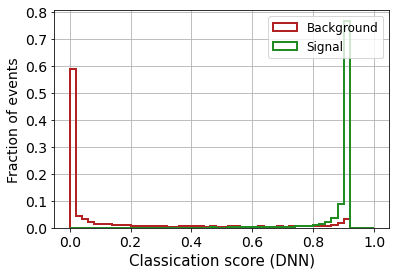


 ROC-AUC =  0.9717617365468981


In [50]:

# define the keras model
model = Sequential()
model.add(Dense(4, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

### CNN

In [45]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
354/354 [==============================] - 1s 989us/step - loss: 64.2715 - accuracy: 0.5058 - val_loss: 0.5343 - val_accuracy: 0.6467
Epoch 2/500
354/354 [==============================] - 0s 550us/step - loss: 2.0359 - accuracy: 0.6486 - val_loss: 0.3795 - val_accuracy: 0.8397
Epoch 3/500
354/354 [==============================] - 0s 514us/step - loss: 0.4181 - accuracy: 0.8194 - val_loss: 0.3124 - val_accuracy: 0.9004
Epoch 4/500
354/354 [==============================] - 0s 516us/step - loss: 0.3395 - accuracy: 0.8652 - val_loss: 0.2254 - val_accuracy: 0.9230
Epoch 5/500
354/354 [==============================] - 0s 524us/step - loss: 0.2665 - accuracy: 0.8985 - val_loss: 0.2032 - val_accuracy: 0.9327
Epoch 6/500
354/354 [==============================] - 0s 507us/step - loss: 0.2520 - accuracy: 0.9021 - val_loss: 0.1965 - val_accuracy: 0.9301
Epoch 7/500
354/354 [==============================] - 0s 512us/step - loss: 0.2396 - accuracy: 0.9089 - val_loss: 0.1884 - val_a

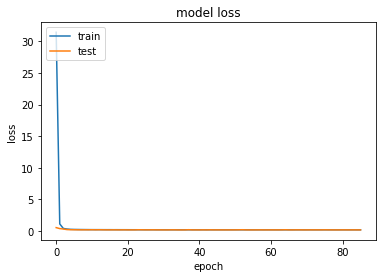

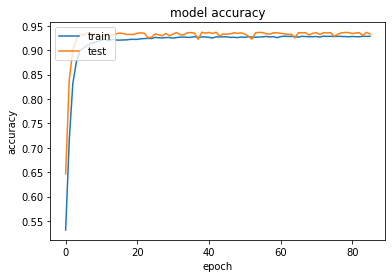

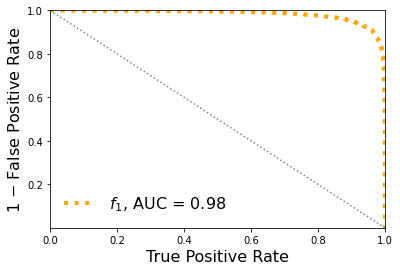

Classification score:


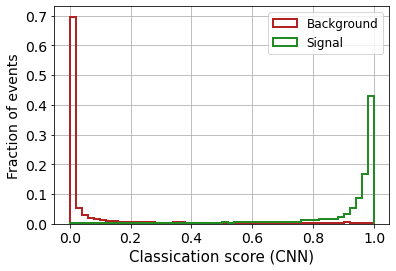


 ROC-AUC =  0.981618453687437


In [47]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
#model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

## 2. only 1 variable: cs2/cs1

In [19]:
# concatenate the data
X_mon_B = np.reshape( (B_cs1cs2[:,1] / B_cs1cs2[:,0]), [len(B_cs1cs2), 1])
X_mon_S = np.reshape( (S_cs1cs2[:,1] / S_cs1cs2[:,0]), [len(S_cs1cs2), 1])

# X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))
# X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))
print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)

# del B_ppeakS1
# del B_ppeakS2
# del B_pbot
# del B_ptop

# del S_ppeakS1
# del S_ppeakS2
# del S_pbot
# del S_ptop

X_mon = np.concatenate([X_mon_B, X_mon_S])

# X_mon = np.concatenate([np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(S_pbot,(len(S_pbot),1))])

print('X_mon.shape: ', X_mon.shape)
# del X_mon_B
# del X_mon_S


# labels
y_mon = np.concatenate([np.zeros(NUM_DAT),np.ones(NUM_DAT)])


# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

X_mon_B.shape:  (35477, 1)
X_mon_S.shape:  (35477, 1)
X_mon.shape:  (70954, 1)

X_mon_train :  (45232, 1)
y_mon_train :  (45232,)
X_mon_val :  (7983, 1)
y_mon_val :  (7983,)
X_mon_test :  (17739, 1)
y_mon_test :  (17739,)



## CLASSIFIERS

### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.68104	validation_1-logloss:0.68082
[1]	validation_0-logloss:0.67116	validation_1-logloss:0.67074
[2]	validation_0-logloss:0.66305	validation_1-logloss:0.66241
[3]	validation_0-logloss:0.65637	validation_1-logloss:0.65558
[4]	validation_0-logloss:0.65076	validation_1-logloss:0.64975
[5]	validation_0-logloss:0.64610	validation_1-logloss:0.64498
[6]	validation_0-logloss:0.64217	validation_1-logloss:0.64092
[7]	validation_0-logloss:0.63890	validation_1-logloss:0.63755
[8]	validation_0-logloss:0.63611	validation_1-logloss:0.63470
[9]	validation_0-logloss:0.63369	validation_1-logloss:0.63236
[10]	validation_0-logloss:0.63171	validation_1-logloss:0.63040
[11]	validation_0-logloss:0.63003	validation_1-logloss:0.62872
[12]	validation_0-logloss:0.62860	validation_1-logloss:0.62730
[13]	validation_0-logloss:0.62738	validation_1-logloss:0.62615
[14]	validation_0-logloss:0.62629	validation_1-logloss:0.62517
[15]	validation_0-logloss:0.62538	validation_1-logloss:0.62430
[1

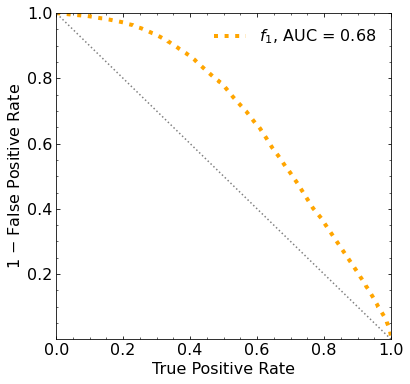

Classification score:


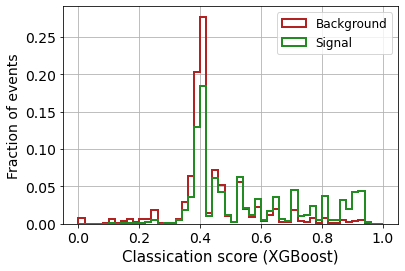


 ROC-AUC =  0.6789745320678433


In [22]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [23]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.6789745320678433


### DNN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 8         
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5

354/354 [==============================] - 0s 544us/step - loss: 0.6474 - accuracy: 0.6013 - val_loss: 0.6348 - val_accuracy: 0.6471
Epoch 105/500
354/354 [==============================] - 0s 545us/step - loss: 0.6527 - accuracy: 0.5948 - val_loss: 0.6444 - val_accuracy: 0.6440
Epoch 106/500
354/354 [==============================] - 0s 535us/step - loss: 0.6490 - accuracy: 0.6012 - val_loss: 0.6324 - val_accuracy: 0.6488
Epoch 107/500
354/354 [==============================] - 0s 538us/step - loss: 0.6508 - accuracy: 0.5943 - val_loss: 0.6376 - val_accuracy: 0.6479
Epoch 108/500
354/354 [==============================] - 0s 548us/step - loss: 0.6500 - accuracy: 0.5993 - val_loss: 0.6334 - val_accuracy: 0.6486
Epoch 109/500
354/354 [==============================] - 0s 543us/step - loss: 0.6508 - accuracy: 0.5956 - val_loss: 0.6306 - val_accuracy: 0.6485
Epoch 110/500
354/354 [==============================] - 0s 531us/step - loss: 0.6470 - accuracy: 0.6031 - val_loss: 0.6372 - val_ac

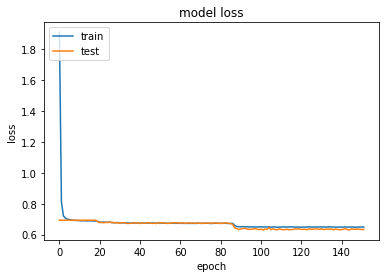

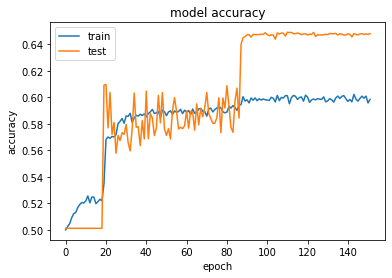

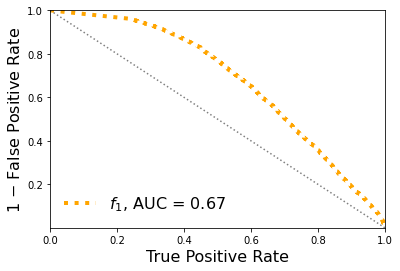

Classification score:


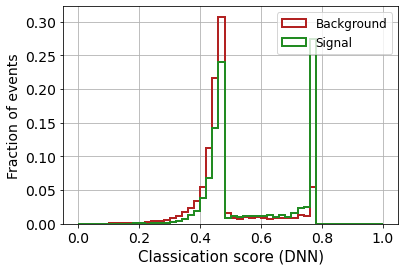


 ROC-AUC =  0.6749524787884603


In [24]:

# define the keras model
model = Sequential()
model.add(Dense(4, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [25]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.6749524787884603
